# Continuous Control

---

In this project we have trained a  policy gradient reinforcement learning agent to solve a [continuous robotic control task](https://github.com/raminzohouri/DDGP-for-ArmRobot-Positioning/tree/maint#environment-details). 
In details, the environment built in 3D space and arm robot need to reach and remain in the target area from randomly initialized positions.
There are 4 action available for controlling the robot by apply torque to its joints. The measured stated contains position, rotation, velocity, and angular velocities of the arm. The task designed episodically and each episode last maximum of $1000$ cycles. Our solution uses a  policy gradient based reinforcement learning algorithm called [CONTINUOUS CONTROL WITH DEEP REINFORCEMENT LEARNING, DDPG](https://arxiv.org/pdf/1509.02971.pdf). The optimal policy should maximize its expected discounted reward $\mu^*(s)=\max_\pi \mathbb{E}[\sum_i \gamma^i r_i]$ by reaching and keeping the end effector of the arm robot in the moving target area. In addition to the vanilla DDPG algorithm we applied a few hyper parameter tuning techniques in order to solve the environment. In the following I will describe each step of our method in details and present the results. In this report the reference to the ideas and publications provide via hyper-link

In [1]:
#!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


In [1]:
import numpy as np
import time
import sys
import os
from collections import deque

In [4]:
cd ../ddpgpositioning

In [5]:
import numpy as np
import time
import sys
import torch
from collections import deque
from agent.ddpg_agent import DDPGAgent
from agent_examples import agent_config_default
from utils import (
    log_training_info,
    save_checkpoint,
    get_training_env,
    load_agent_parameters,
)


In [6]:

def ddpg_runner(
    env,
    brain_name="Reacher",
    state_size=33,
    action_size=4,
    n_episodes=100,
    max_t=1000,
    agent_config={},
    target_episodes=100,
    target_score=30,
    num_agents=20,
    print_log=False,
    run_mode="train",
    saved_checkpoint_path="model/checkpoint.pth",
):
    """
    Deep Deterministic Policy Gradients (DDPG).
    Parameters
    ----------
    env :
    brain_name :
    state_size :
    action_size :
    n_episodes :
    max_t :
    agent_config :
    target_episodes :
    target_score :
    num_agents :
    print_log :
    run_mode:
    saved_checkpoint_path:
    Returns
    -------

    """
    scores = []  # episodic scores
    training_info_log = []  # training time and meta data logger
    moving_avg = deque(maxlen=100)  # last 100 scores
    agent_config_default["action_size"] = action_size
    agent_config_default["state_size"] = state_size
    agent = DDPGAgent(**agent_config)
    if run_mode == "test":
        load_agent_parameters(agent, saved_checkpoint_path)
        agent.actor_local.eval()
        agent.critic_local.eval()
    ## Perform n_episodes of training
    training_start_time = time.time()
    for i_episode in range(1, n_episodes + 1):
        episode_start_time = time.time()
        agent.noise.reset()
        states = env.reset(train_mode=run_mode == "train")[
            brain_name
        ].vector_observations
        scores_episode = np.zeros(num_agents)  # rewards per episode for each agent

        for t in range(1, max_t + 1):
            # Perform a step: S;A;R;S'
            actions = agent.act(states)  # select the next action for each agent
            env_info = env.step(actions)[
                brain_name
            ]  # send the actions to the environment
            rewards = env_info.rewards  # get the rewards
            next_states = env_info.vector_observations  # get the next states
            dones = env_info.local_done  # see if episode has finished
            # Send the results to the Agent
            if run_mode == "train":
                for i, (state, action, reward, next_state, done) in enumerate(
                    zip(states, actions, rewards, next_states, dones)
                ):
                    agent.step(state, action, reward, next_state, done)
            # Update the variables for the next iteration
            states = next_states
            scores_episode += rewards

        if run_mode == "test":
            continue
        # Store the rewards and calculate the moving average
        scores.append(scores_episode.tolist())
        moving_avg.append(np.mean(scores[-target_episodes:], axis=0))

        training_info_log.append(
            log_training_info(
                i_episode,
                training_start_time,
                episode_start_time,
                scores_episode,
                moving_avg,
                print_log=print_log,
            )
        )
        ## Check if the environment has been solved
        if moving_avg[-1].mean() >= target_score and i_episode >= target_episodes:
            save_checkpoint(
                i_episode,
                scores,
                moving_avg,
                training_info_log,
                agent,
                agent_config,
                training_start_time,
                target_episodes,
            )
            print("\n done.")
            break

    return scores, moving_avg, agent, training_info_log


In [7]:
env_file_path = "../../Reacher_Linux_NoVis/Reacher.x86_64"
env, num_agents, brain_name, state_size, action_size = get_training_env(
        env_file_path, test_mode="train"
    )



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [11]:
scores, moving_avg, agent, training_info_log = ddpg_runner(
    env=env,
    brain_name=brain_name,
    state_size=state_size,
    action_size=action_size,
    n_episodes=1,
    max_t=10,
    agent_config=agent_config_default,
    num_agents=num_agents,
    print_log=True,
    run_mode="train",
    saved_checkpoint_path="",
)

DDPG Agent hyperparameters:
	
 {'agent_name': 'ddpg-plain', 'state_size': 33, 'action_size': 4, 'critic_state_hidden_layers': [400], 'critic_action_hidden_layers': [400, 300], 'critic_hidden_activation': 'ReLU', 'critic_output_activation': 'Sigmoid', 'critic_use_batchnorm': False, 'actor_hidden_layers': [400, 300], 'actor_hidden_activation': 'ReLU', 'actor_output_activation': 'Tanh', 'actor_use_batchnorm': False, 'w_init': 0.003, 'seed': 0, 'gamma': 0.99, 'tau': 0.001, 'batch_size': 128, 'lr_actor': 0.001, 'lr_critic': 0.001, 'clip_gradient_critic': True, 'clip_gradient_norm': 1.0, 'clip_gradient_actor': False, 'noise_decay': 0.999, 'update_every': 2, 'buffer_size': 100000.0, 'combined_reply_buffer': False}
Actor Network : ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=4, bias=True)
)
Actor Network : ModuleList(
  (0): Linear(in_fea

In [7]:
checkpoint = torch.load("../model/checkpoint_ddpg-plain_episode_120.pth")
checkpoint.keys()

dict_keys(['agent_config', 'actor_state_dict', 'actor_optimizer_state_dict', 'critic_state_dict', 'critic_optimizer_state_dict', 'number_of_episode', 'scores', 'moving_avg'])

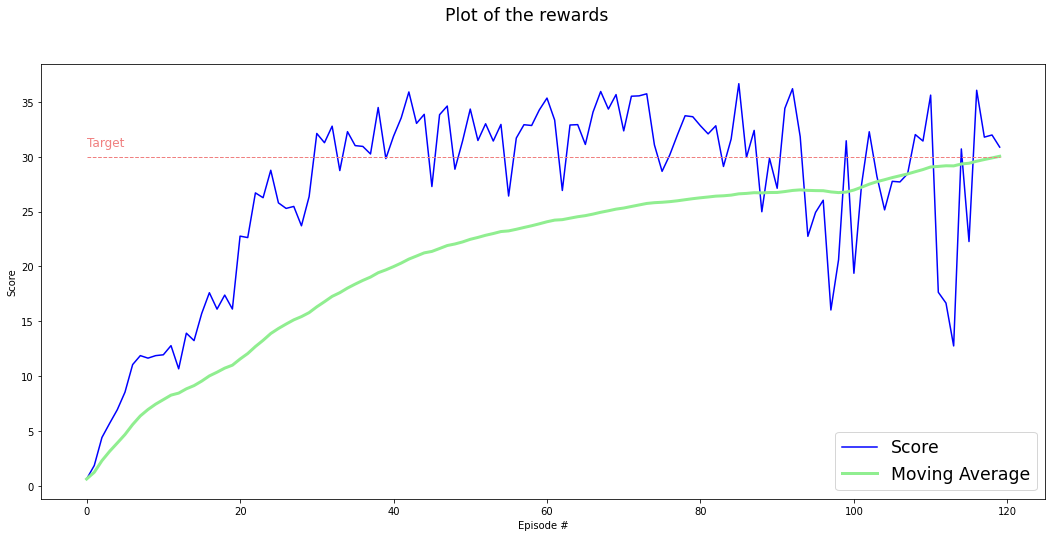

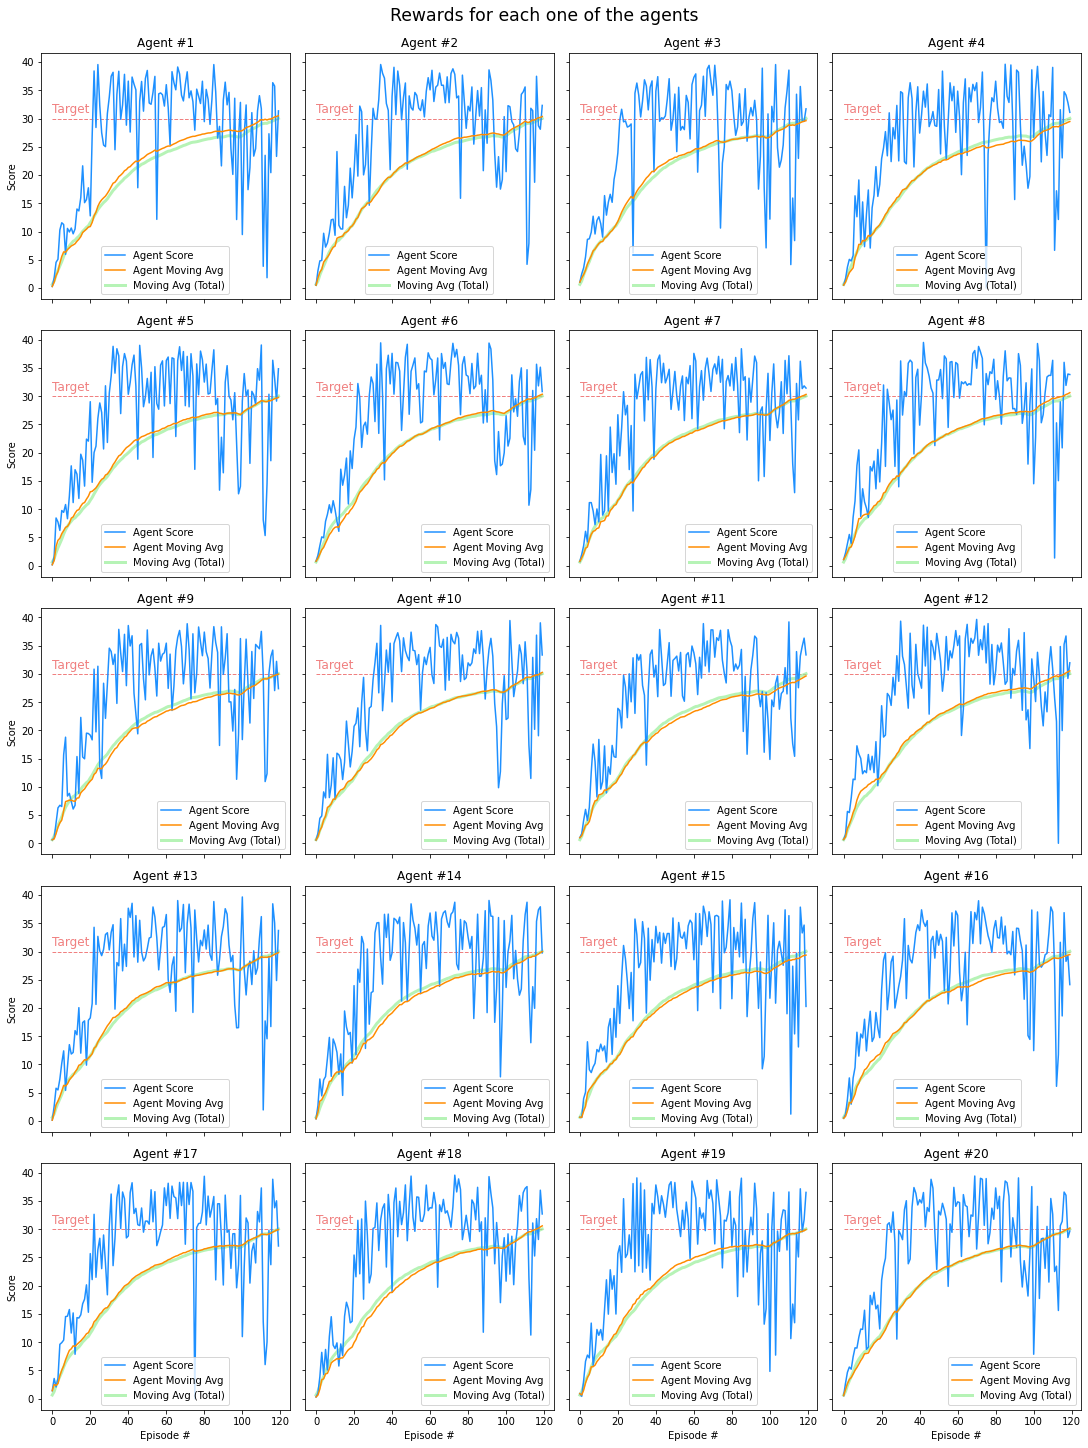

In [17]:
# Preprocess some variables
from matplotlib import pyplot as plt
scores = checkpoint["scores"]
moving_avg = checkpoint["moving_avg"]
_target_score = 30
scores_mean = np.mean(scores, axis=1)
moving_avg_mean = np.mean(moving_avg, axis=1)
target = [_target_score] * len(scores) # Trace a line indicating the target value

# Plot the main graph with the scores and moving average
fig = plt.figure(figsize=(18,8))
fig.suptitle('Plot of the rewards', fontsize='xx-large')

ax = fig.add_subplot(111)
ax.plot(scores_mean, label='Score', color='Blue')
ax.plot(moving_avg_mean, label='Moving Average',
        color='LightGreen', linewidth=3)
ax.plot(target, linestyle='--', color='LightCoral', linewidth=1 )
ax.text(0, _target_score+1, 'Target', color='LightCoral', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='xx-large', loc='lower right')

plt.show()

# Plot one graph for each one of the 20 Agents, if that is the case
if len(scores[0]) == 20:
    fig, axs = plt.subplots(5, 4, figsize=(15, 20),
                            constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle('Rewards for each one of the agents', fontsize='xx-large')

    axs = axs.flatten()
    for idx, (ax, s, m) \
            in enumerate(zip(axs, np.transpose(scores), np.transpose(moving_avg))):
        ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=2)
        ax.plot(m, label='Agent Moving Avg', color='DarkOrange', zorder=3)
        ax.plot(moving_avg_mean, label='Moving Avg (Total)',
                color='LightGreen', linewidth=3, alpha=0.655, zorder=1)
        ax.plot(target, linestyle='--', color='LightCoral', linewidth=1, zorder=0)
        ax.text(0, _target_score+1, 'Target', color='LightCoral', fontsize='large')

        ax.set_title('Agent #%d' % (idx+1))
        ax.set_ylabel('Score')
        ax.set_xlabel('Episode #')
        ax.label_outer()
        ax.legend(fontsize='medium')

    plt.show()